In [391]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [392]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [393]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

   

    return train_data, train_label, test_data, test_label

In [394]:
class EEGNetELU(torch.nn.Module):
    def __init__(self):
        super(EEGNetELU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class EEGNetReLU(nn.Module):
    def __init__(self):
        super(EEGNetReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class EEGNetLeakyReLU(nn.Module):
    def __init__(self):
        super(EEGNetLeakyReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class DeepConvNetELU(torch.nn.Module):
    def __init__(self):
        super(DeepConvNetELU, self).__init__()
        self.model = nn.Sequential(
            # Conv2d(1, 25, kernel_size=(1,5),padding='VALID',bias=False),
            # Conv2d(25, 25, kernel_size=(2,1), padding='VALID',bias=False),
            nn.Conv2d(1, 25, kernel_size=(1,5), padding='valid'),
            nn.Conv2d(25, 25, kernel_size=(2,1), padding='valid'),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=0.4),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(25, 50, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(25, 50, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=0.4),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(50, 100, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(50, 100, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=0.4),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(100, 200, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(100, 200, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ELU(alpha=0.4),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Flatten(),
            nn.Linear(8600,2,bias=True)
        )

    def forward(self, x):
        out = self.model(x)
        return out
    
class DeepConvNetReLU(nn.Module):
    def __init__(self):
        super(DeepConvNetReLU, self).__init__()
        self.model = nn.Sequential(
            # Conv2d(1, 25, kernel_size=(1,5),padding='VALID',bias=False),
            # Conv2d(25, 25, kernel_size=(2,1), padding='VALID',bias=False),
            nn.Conv2d(1, 25, kernel_size=(1,5), padding='valid'),
            nn.Conv2d(25, 25, kernel_size=(2,1), padding='valid'),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(25, 50, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(25, 50, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(50, 100, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(50, 100, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(100, 200, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(100, 200, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Flatten(),
            nn.Linear(8600,2,bias=True)
        )

    def forward(self, x):
        out = self.model(x)
        return out
    
class DeepConvNetLeakyReLU(nn.Module):
    def __init__(self):
        super(DeepConvNetLeakyReLU, self).__init__()
        self.model = nn.Sequential(
            # Conv2d(1, 25, kernel_size=(1,5),padding='VALID',bias=False),
            # Conv2d(25, 25, kernel_size=(2,1), padding='VALID',bias=False),
            nn.Conv2d(1, 25, kernel_size=(1,5), padding='valid'),
            nn.Conv2d(25, 25, kernel_size=(2,1), padding='valid'),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.04),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(25, 50, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(25, 50, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.04),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(50, 100, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(50, 100, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.04),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            # Conv2d(100, 200, kernel_size=(1,5),padding='VALID',bias=False),
            nn.Conv2d(100, 200, kernel_size=(1,5), padding='valid'),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.04),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Flatten(),
            nn.Linear(8600,2,bias=True)
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [395]:
def evaluate(model, X, Y):
    results = []
    batch_size = 64
    predicted = []
        
    inputs = Variable(torch.FloatTensor(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    predicted = np.argmax(predicted, axis=1)
    # print(type(predicted))
    results = accuracy_score(Y, np.round(predicted))
    return results
train_data, train_label, test_data, test_label = read_bci_data()

In [396]:
import torch.optim.lr_scheduler as lr
ELU = EEGNetELU().cuda(0)
ReLU = EEGNetReLU().cuda(0)
LeakyReLU = EEGNetLeakyReLU().cuda(0)
criterion = nn.CrossEntropyLoss()
ELU_optimizer = optim.RMSprop(ELU.parameters(),lr = 1e-3, momentum = 0.6)
ReLU_optimizer = optim.RMSprop(ReLU.parameters(),lr = 1e-3, momentum = 0.6)
LeakyReLU_optimizer = optim.RMSprop(LeakyReLU.parameters(),lr = 1e-3, momentum = 0.6)
ELU_scheduler = lr.MultiStepLR(ELU_optimizer, milestones=[400,500,700], gamma=0.5)
ReLU_scheduler = lr.MultiStepLR(ReLU_optimizer, milestones=[400,500,700], gamma=0.5)
LeakyReLU_scheduler = lr.MultiStepLR(LeakyReLU_optimizer, milestones=[400,500,700], gamma=0.5)

In [397]:

ELU_Deep = DeepConvNetELU().cuda(0)
ReLU_Deep = DeepConvNetReLU().cuda(0)
LeakyReLU_Deep = DeepConvNetLeakyReLU().cuda(0)
criterion = nn.CrossEntropyLoss()
ELU_Deep_optimizer = optim.RMSprop(ELU_Deep.parameters(),lr = 1e-3, momentum = 0.9, weight_decay=1e-3)
ReLU_Deep_optimizer = optim.RMSprop(ReLU_Deep.parameters(),lr = 1e-3, momentum = 0.9, weight_decay=1e-3)
LeakyReLU_Deep_optimizer = optim.RMSprop(LeakyReLU_Deep.parameters(),lr = 1e-3, momentum = 0.9, weight_decay=1e-3)
ELU_Deep_scheduler = lr.MultiStepLR(ELU_Deep_optimizer, milestones=[600, 1200], gamma=0.5)
ReLU_Deep_scheduler = lr.MultiStepLR(ReLU_Deep_optimizer, milestones=[600, 1200], gamma=0.5)
LeakyReLU_Deep_scheduler = lr.MultiStepLR(LeakyReLU_Deep_optimizer, milestones=[600, 1200], gamma=0.5)

In [398]:
ELU_total_train_acc = []
ELU_total_val_acc = []
ELU_max_train_acc = 0
ELU_max_val_acc = 0

ReLU_total_train_acc = []
ReLU_total_val_acc = []
ReLU_max_train_acc = 0
ReLU_max_val_acc = 0

LeakyReLU_total_train_acc = []
LeakyReLU_total_val_acc = []
LeakyReLU_max_train_acc = 0
LeakyReLU_max_val_acc = 0

ELU_Deep_total_train_acc = []
ELU_Deep_total_val_acc = []
ELU_Deep_max_train_acc = 0
ELU_Deep_max_val_acc = 0

ReLU_Deep_total_train_acc = []
ReLU_Deep_total_val_acc = []
ReLU_Deep_max_train_acc = 0
ReLU_Deep_max_val_acc = 0

LeakyReLU_Deep_total_train_acc = []
LeakyReLU_Deep_total_val_acc = []
LeakyReLU_Deep_max_train_acc = 0
LeakyReLU_Deep_max_val_acc = 0

batch_size = 1080
for epoch in range(3000):  # loop over the dataset multiple times
    print("Epoch ", epoch + 1)
    running_loss = 0.0
    for i in range(int(len(train_data)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.FloatTensor(train_data[s:e])
        labels = torch.FloatTensor(train_label[s:e]).type(torch.LongTensor)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

        # zero the parameter gradients
        ELU_optimizer.zero_grad()
        ReLU_optimizer.zero_grad()
        LeakyReLU_optimizer.zero_grad()
        ELU_Deep_optimizer.zero_grad()
        ReLU_Deep_optimizer.zero_grad()
        LeakyReLU_Deep_optimizer.zero_grad()

        # forward + backward + optimize
        ELU_outputs = ELU(inputs)
        ReLU_outputs = ReLU(inputs)
        LeakyReLU_outputs = LeakyReLU(inputs)
        ELU_Deep_outputs = ELU_Deep(inputs)
        ReLU_Deep_outputs = ReLU_Deep(inputs)
        LeakyReLU_Deep_outputs = LeakyReLU_Deep(inputs)

        # print(outputs.shape, labels.shape)
        ELU_loss = criterion(ELU_outputs, labels)
        ELU_loss.backward()
        ELU_optimizer.step()
        ELU_scheduler.step()
        running_loss += ELU_loss.item()

        ReLU_loss = criterion(ReLU_outputs, labels)
        ReLU_loss.backward()
        ReLU_optimizer.step()
        ReLU_scheduler.step()

        LeakyReLU_loss = criterion(LeakyReLU_outputs, labels)
        LeakyReLU_loss.backward()
        LeakyReLU_optimizer.step()
        LeakyReLU_scheduler.step()

        ELU_Deep_loss = criterion(ELU_Deep_outputs, labels)
        ELU_Deep_loss.backward()
        ELU_Deep_optimizer.step()
        ELU_Deep_scheduler.step()

        ReLU_Deep_loss = criterion(ReLU_Deep_outputs, labels)
        ReLU_Deep_loss.backward()
        ReLU_Deep_optimizer.step()
        ReLU_Deep_scheduler.step()

        LeakyReLU_Deep_loss = criterion(LeakyReLU_Deep_outputs, labels)
        LeakyReLU_Deep_loss.backward()
        LeakyReLU_Deep_optimizer.step()
        LeakyReLU_Deep_scheduler.step()


    ELU_train_acc = evaluate(ELU, train_data, train_label)
    ELU_val_acc = evaluate(ELU, test_data, test_label)
    if ELU_train_acc > ELU_max_train_acc:
        ELU_max_train_acc = ELU_train_acc
    if ELU_val_acc > ELU_max_val_acc:
        ELU_max_val_acc = ELU_val_acc

    ReLU_train_acc = evaluate(ReLU, train_data, train_label)
    ReLU_val_acc = evaluate(ReLU, test_data, test_label)
    if ReLU_train_acc > ReLU_max_train_acc:
        ReLU_max_train_acc = ReLU_train_acc
    if ReLU_val_acc > ReLU_max_val_acc:
        ReLU_max_val_acc = ReLU_val_acc

    LeakyReLU_train_acc = evaluate(LeakyReLU, train_data, train_label)
    LeakyReLU_val_acc = evaluate(LeakyReLU, test_data, test_label)
    if LeakyReLU_train_acc > ELU_max_train_acc:
        LeakyReLU_max_train_acc = LeakyReLU_train_acc
    if LeakyReLU_val_acc > LeakyReLU_max_val_acc:
        LeakyReLU_max_val_acc = LeakyReLU_val_acc

    ELU_Deep_train_acc = evaluate(ELU_Deep, train_data, train_label)
    ELU_Deep_val_acc = evaluate(ELU_Deep, test_data, test_label)
    if ELU_Deep_train_acc > ELU_Deep_max_train_acc:
        ELU_Deep_max_train_acc = ELU_Deep_train_acc
    if ELU_Deep_val_acc > ELU_Deep_max_val_acc:
        ELU_Deep_max_val_acc = ELU_Deep_val_acc

    ReLU_Deep_train_acc = evaluate(ReLU_Deep, train_data, train_label)
    ReLU_Deep_val_acc = evaluate(ReLU_Deep, test_data, test_label)
    if ReLU_Deep_train_acc > ReLU_Deep_max_train_acc:
        ReLU_Deep_max_train_acc = ReLU_Deep_train_acc
    if ReLU_Deep_val_acc > ReLU_Deep_max_val_acc:
        ReLU_Deep_max_val_acc = ReLU_Deep_val_acc

    LeakyReLU_Deep_train_acc = evaluate(LeakyReLU_Deep, train_data, train_label)
    LeakyReLU_Deep_val_acc = evaluate(LeakyReLU_Deep, test_data, test_label)
    if LeakyReLU_Deep_train_acc > LeakyReLU_Deep_max_train_acc:
        LeakyReLU_Deep_max_train_acc = LeakyReLU_Deep_train_acc
    if LeakyReLU_Deep_val_acc > LeakyReLU_Deep_max_val_acc:
        LeakyReLU_Deep_max_val_acc = LeakyReLU_Deep_val_acc


    ELU_total_train_acc.append(ELU_train_acc)
    ELU_total_val_acc.append(ELU_val_acc)

    ReLU_total_train_acc.append(ReLU_train_acc)
    ReLU_total_val_acc.append(ReLU_val_acc)

    LeakyReLU_total_train_acc.append(LeakyReLU_train_acc)
    LeakyReLU_total_val_acc.append(LeakyReLU_val_acc)

    ELU_Deep_total_train_acc.append(ELU_Deep_train_acc)
    ELU_Deep_total_val_acc.append(ELU_Deep_val_acc)

    ReLU_Deep_total_train_acc.append(ReLU_Deep_train_acc)
    ReLU_Deep_total_val_acc.append(ReLU_Deep_val_acc)

    LeakyReLU_Deep_total_train_acc.append(LeakyReLU_Deep_train_acc)
    LeakyReLU_Deep_total_val_acc.append(LeakyReLU_Deep_val_acc)
    

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Epoch  30
Epoch  31
Epoch  32
Epoch  33
Epoch  34
Epoch  35
Epoch  36
Epoch  37
Epoch  38
Epoch  39
Epoch  40
Epoch  41
Epoch  42
Epoch  43
Epoch  44
Epoch  45
Epoch  46
Epoch  47
Epoch  48
Epoch  49
Epoch  50
Epoch  51
Epoch  52
Epoch  53
Epoch  54
Epoch  55
Epoch  56
Epoch  57
Epoch  58
Epoch  59
Epoch  60
Epoch  61
Epoch  62
Epoch  63
Epoch  64
Epoch  65
Epoch  66
Epoch  67
Epoch  68
Epoch  69
Epoch  70
Epoch  71
Epoch  72
Epoch  73
Epoch  74
Epoch  75
Epoch  76
Epoch  77
Epoch  78
Epoch  79
Epoch  80
Epoch  81
Epoch  82
Epoch  83
Epoch  84
Epoch  85
Epoch  86
Epoch  87
Epoch  88
Epoch  89
Epoch  90
Epoch  91
Epoch  92
Epoch  93
Epoch  94
Epoch  95
Epoch  96
Epoch  97
Epoch  98
Epoch  99
Epoch  100
Epoch  1

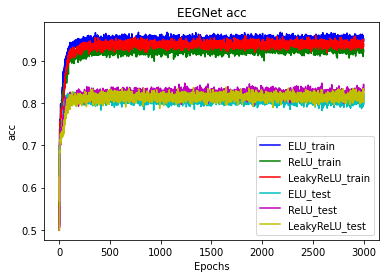

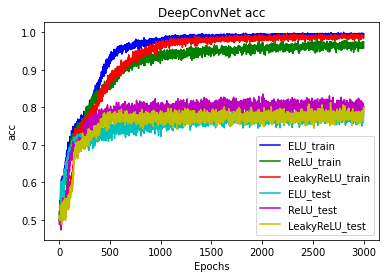

EEGNet with ELU            Max train Acc = 0.9675925925925926
EEGNet with ReLU           Max train Acc = 0.9472222222222222
EEGNet with LeakyReLU      Max train Acc = 0
EEGNet with ELU            Max test Acc  = 0.8342592592592593
EEGNet with ReLU           Max test Acc  = 0.8472222222222222
EEGNet with LeakyReLU      Max test Acc  = 0.8379629629629629
DeepConvNet with ELU       Max train Acc = 1.0
DeepConvNet with ReLU      Max train Acc = 0.9814814814814815
DeepConvNet with LeakyReLU Max train Acc = 0.9962962962962963
DeepConvNet with ELU       Max test Acc  = 0.8083333333333333
DeepConvNet with ReLU      Max test Acc  = 0.8351851851851851
DeepConvNet with LeakyReLU Max test Acc  = 0.812962962962963


In [400]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch

# val_loss = history.history['val_loss']
epochs = range(1, len(ELU_total_train_acc) + 1)
plt.plot(epochs, ELU_total_train_acc, label='ELU_train', color='b')
plt.plot(epochs, ReLU_total_train_acc, label='ReLU_train', color='g')
plt.plot(epochs, LeakyReLU_total_train_acc, label='LeakyReLU_train', color='r')
plt.plot(epochs, ELU_total_val_acc, label='ELU_test', color='c')
plt.plot(epochs, ReLU_total_val_acc, label='ReLU_test', color='m')
plt.plot(epochs, LeakyReLU_total_val_acc, label='LeakyReLU_test', color='y')
plt.title('EEGNet acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

epochs = range(1, len(ELU_Deep_total_train_acc) + 1)
plt.plot(epochs, ELU_Deep_total_train_acc, label='ELU_train', color='b')
plt.plot(epochs, ReLU_Deep_total_train_acc, label='ReLU_train', color='g')
plt.plot(epochs, LeakyReLU_Deep_total_train_acc, label='LeakyReLU_train', color='r')
plt.plot(epochs, ELU_Deep_total_val_acc, label='ELU_test', color='c')
plt.plot(epochs, ReLU_Deep_total_val_acc, label='ReLU_test', color='m')
plt.plot(epochs, LeakyReLU_Deep_total_val_acc, label='LeakyReLU_test', color='y')
plt.title('DeepConvNet acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

print(f"{'EEGNet with ELU' : <27}{'Max train Acc' : <14}{'= '}{ELU_max_train_acc}")
print(f"{'EEGNet with ReLU' : <27}{'Max train Acc' : <14}{'= '}{ReLU_max_train_acc}")
print(f"{'EEGNet with LeakyReLU' : <27}{'Max train Acc' : <14}{'= '}{LeakyReLU_max_train_acc}")
print(f"{'EEGNet with ELU' : <27}{'Max test Acc' : <14}{'= '}{ELU_max_val_acc}")
print(f"{'EEGNet with ReLU' : <27}{'Max test Acc' : <14}{'= '}{ReLU_max_val_acc}")
print(f"{'EEGNet with LeakyReLU' : <27}{'Max test Acc' : <14}{'= '}{LeakyReLU_max_val_acc}")

print(f"{'DeepConvNet with ELU' : <27}{'Max train Acc' : <14}{'= '}{ELU_Deep_max_train_acc}")
print(f"{'DeepConvNet with ReLU' : <27}{'Max train Acc' : <14}{'= '}{ReLU_Deep_max_train_acc}")
print(f"{'DeepConvNet with LeakyReLU' : <27}{'Max train Acc' : <14}{'= '}{LeakyReLU_Deep_max_train_acc}")
print(f"{'DeepConvNet with ELU' : <27}{'Max test Acc' : <14}{'= '}{ELU_Deep_max_val_acc}")
print(f"{'DeepConvNet with ReLU' : <27}{'Max test Acc' : <14}{'= '}{ReLU_Deep_max_val_acc}")
print(f"{'DeepConvNet with LeakyReLU' : <27}{'Max test Acc' : <14}{'= '}{LeakyReLU_Deep_max_val_acc}")